## Early Fusion

#### Preprocessing

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet

# Define paths
image_dir = r'C:\Users\Vlad\Documents\James Thesis\Early Fusion\Images'
clinical_data_path = r'C:\Users\Vlad\Documents\James Thesis\Early Fusion\Clinical Covariates Preprocessed.xlsx'

# Load clinical data
clinical_data = pd.read_excel(clinical_data_path)
clinical_data['Study Number'] = clinical_data['Study Number'].astype(str)  # Convert Study Number to string

# Map the classification to readable labels
classification_map = {
    1: 'Normal',
    2: 'Osteopenia',
    3: 'Osteoporosis'
}
clinical_data['label'] = clinical_data['Osteoporosis Classification'].map(classification_map)

# Handle NaN values in 'Osteoporosis Classification' or 'Study Number'
clinical_data = clinical_data.dropna(subset=['Osteoporosis Classification', 'Study Number'])
clinical_data['Osteoporosis Classification'] = clinical_data['Osteoporosis Classification'].astype(int)

# Function to construct image paths
def get_image_path(row):
    try:
        label = str(row['label'])
        study_number = str(row['Study Number']).zfill(8)  # Pad with zeros up to 8 digits
        path = os.path.join(image_dir, label, f"{study_number}.JPG")
        return path if os.path.exists(path) else None
    except KeyError:
        return None

# Apply the function to the DataFrame
clinical_data['image_path'] = clinical_data.apply(get_image_path, axis=1)

# Drop rows without valid image paths
clinical_data = clinical_data.dropna(subset=['image_path'])

# Split the data into training, validation, and test sets with stratification
train_df, temp_df = train_test_split(clinical_data, test_size=0.2, stratify=clinical_data['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Data Generators
def create_data_generators(dataframe, target_size_resnet=(224, 224), target_size_effnet=(300, 300), batch_size=32):
    # Initialize the data generators with preprocessing functions
    datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_resnet50)
    datagen_effnet = ImageDataGenerator(preprocessing_function=preprocess_efficientnet)

    # Create generators for ResNet50
    generator_resnet = datagen_resnet.flow_from_dataframe(
        dataframe=dataframe,
        x_col='image_path',
        y_col='label',
        target_size=target_size_resnet,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Create generators for EfficientNetB3
    generator_effnet = datagen_effnet.flow_from_dataframe(
        dataframe=dataframe,
        x_col='image_path',
        y_col='label',
        target_size=target_size_effnet,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return generator_resnet, generator_effnet

# Create data generators for training, validation, and test sets
train_gen_resnet, train_gen_effnet = create_data_generators(train_df)
val_gen_resnet, val_gen_effnet = create_data_generators(val_df)
test_gen_resnet, test_gen_effnet = create_data_generators(test_df)

# Print dataset sizes to confirm correct splits
print("Training Set Size: ", len(train_df))
print("Validation Set Size: ", len(val_df))
print("Test Set Size: ", len(test_df))


Found 324 validated image filenames belonging to 3 classes.
Found 324 validated image filenames belonging to 3 classes.
Found 41 validated image filenames belonging to 3 classes.
Found 41 validated image filenames belonging to 3 classes.
Found 41 validated image filenames belonging to 3 classes.
Found 41 validated image filenames belonging to 3 classes.
Training Set Size:  324
Validation Set Size:  41
Test Set Size:  41


#### Concatenation

In [2]:
import numpy as np

# One-hot encode clinical data
clinical_features = clinical_data[['Normalized Age', 'Gender Male', 'Gender Female']].values

# Split clinical data based on the previously created splits
train_clinical = clinical_features[:len(train_df)]
val_clinical = clinical_features[len(train_df):len(train_df)+len(val_df)]
test_clinical = clinical_features[-len(test_df):]

print("Clinical data prepared:")
print(f"Train clinical data shape: {train_clinical.shape}")
print(f"Validation clinical data shape: {val_clinical.shape}")
print(f"Test clinical data shape: {test_clinical.shape}")

Clinical data prepared:
Train clinical data shape: (324, 3)
Validation clinical data shape: (41, 3)
Test clinical data shape: (41, 3)


In [3]:
images, labels = next(iter(train_gen_resnet))
print(f"First batch shape: {images.shape}, Labels shape: {labels.shape}")


First batch shape: (32, 224, 224, 3), Labels shape: (32, 3)


In [4]:
# Reset the indices of clinical_data
clinical_data = clinical_data.reset_index(drop=True)

# Extract clinical features (Normalized Age, Gender Male, Gender Female)
clinical_features = clinical_data[['Normalized Age', 'Gender Male', 'Gender Female']].values

In [5]:
def embed_clinical_into_images(generator, clinical_data):
    """
    Embed clinical data into image channels.
    Ensure the clinical data aligns with the image batch sizes.
    """
    modified_images = []
    modified_labels = []
    clinical_index = 0  # Tracks the index of clinical data used

    for images, labels in generator:
        batch_size = images.shape[0]  # Get the batch size of images

        # Extract the matching clinical data for this batch
        batch_clinical = clinical_data[clinical_index:clinical_index + batch_size]

        # Ensure clinical data batch size matches image batch size
        if len(batch_clinical) != batch_size:
            print(f"Skipping batch. Expected batch size {batch_size}, got {len(batch_clinical)}.")
            break

        # Reshape clinical data to (batch_size, 1, 1, num_features)
        batch_clinical = np.expand_dims(batch_clinical, axis=(1, 2))  # Add height and width dimensions

        # Repeat clinical data along height and width dimensions
        batch_clinical = np.repeat(batch_clinical, images.shape[1], axis=1)  # Repeat along height
        batch_clinical = np.repeat(batch_clinical, images.shape[2], axis=2)  # Repeat along width

        # Concatenate clinical data as additional channels
        combined_images = np.concatenate((images, batch_clinical), axis=3)  # Add clinical as additional channels

        # Append results
        modified_images.append(combined_images)
        modified_labels.append(labels)

        # Increment the clinical index
        clinical_index += batch_size

    if len(modified_images) > 0 and len(modified_labels) > 0:
        return np.concatenate(modified_images), np.concatenate(modified_labels)
    else:
        raise ValueError("No valid batches were processed.")


# Apply to train, validation, and test datasets
train_images_with_clinical, train_labels = embed_clinical_into_images(train_gen_resnet, train_clinical)
val_images_with_clinical, val_labels = embed_clinical_into_images(val_gen_resnet, val_clinical)
test_images_with_clinical, test_labels = embed_clinical_into_images(test_gen_resnet, test_clinical)

# Confirm shapes
print(f"Train images with clinical shape: {train_images_with_clinical.shape}")
print(f"Validation images with clinical shape: {val_images_with_clinical.shape}")
print(f"Test images with clinical shape: {test_images_with_clinical.shape}")

Skipping batch. Expected batch size 32, got 0.
Skipping batch. Expected batch size 32, got 0.
Skipping batch. Expected batch size 32, got 0.
Train images with clinical shape: (324, 224, 224, 6)
Validation images with clinical shape: (41, 224, 224, 6)
Test images with clinical shape: (41, 224, 224, 6)


In [6]:
print(f"Clinical data size: {len(clinical_data)}")
print(f"Number of samples in generator: {train_gen_resnet.n}")  # Total samples in generator

Clinical data size: 406
Number of samples in generator: 324


#### Creating Data Loaders

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for PyTorch
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensors
        image = torch.tensor(image).permute(2, 0, 1).float()  # Change to [channels, height, width]
        label = torch.tensor(label).long()  # Assuming labels are class indices
        return image, label

# Create Dataset objects
train_dataset = CustomDataset(train_images_with_clinical, train_labels)
val_dataset = CustomDataset(val_images_with_clinical, val_labels)
test_dataset = CustomDataset(test_images_with_clinical, test_labels)

# Create DataLoaders
batch_size = 16  # Adjust batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Train Dataset Size: 324
Validation Dataset Size: 41
Test Dataset Size: 41


In [8]:
# Data Generators for RGB Images
def create_data_generators(dataframe, target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet50)  # Default preprocessing for ResNet50
    
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    return generator

# Train, validation, and test generators
train_gen = create_data_generators(train_df)
val_gen = create_data_generators(val_df)
test_gen = create_data_generators(test_df)

Found 324 validated image filenames belonging to 3 classes.
Found 41 validated image filenames belonging to 3 classes.
Found 41 validated image filenames belonging to 3 classes.


#### Model Training

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models 
from efficientnet_pytorch import EfficientNet  
from tqdm import tqdm
import numpy as np

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Prepare datasets for PyTorch
def prepare_dataloader(images, labels, batch_size):
    tensor_x = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # Channels-first
    tensor_y = torch.tensor(np.argmax(labels, axis=1), dtype=torch.long)  # Convert one-hot to class indices
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 16  # Adjust as needed
train_loader = prepare_dataloader(train_images_with_clinical, train_labels, batch_size)
val_loader = prepare_dataloader(val_images_with_clinical, val_labels, batch_size)
test_loader = prepare_dataloader(test_images_with_clinical, test_labels, batch_size)

Using device: cuda


In [10]:
# Initialize models
# ResNet50
resnet50_model = models.resnet50(pretrained=True)
resnet50_model.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust input channels
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 3)  # 3 output classes
resnet50_model.to(device)

# EfficientNetB3
efficientnetb3_model = EfficientNet.from_name('efficientnet-b3')
efficientnetb3_model._conv_stem = nn.Conv2d(6, 40, kernel_size=3, stride=2, bias=False)  # Adjust input channels
efficientnetb3_model._fc = nn.Linear(efficientnetb3_model._fc.in_features, 3)  # 3 output classes
efficientnetb3_model.to(device)

# Hyperparameters
config = {
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "scheduler_step_size": 5,
    "scheduler_gamma": 0.5,
    "num_epochs": 50
}

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

c:\Users\Vlad\Anaconda\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vlad\Anaconda\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
def train_model(model, train_loader, val_loader, criterion, config, device):
    # Initialize optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["scheduler_step_size"], gamma=config["scheduler_gamma"])

    # Track the best validation accuracy
    best_val_accuracy = 0.0

    for epoch in range(1, config["num_epochs"] + 1):
        print(f"Epoch {epoch}/{config['num_epochs']}")
        print('-' * 10)

        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}/{config['num_epochs']}")

        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            train_bar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct / total
        print(f"Training Loss: {train_loss:.4f} Acc: {train_accuracy:.4f}")

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_bar = tqdm(val_loader, desc=f"Validating Epoch {epoch}/{config['num_epochs']}")

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Metrics
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                # Update progress bar
                val_bar.set_postfix(loss=loss.item(), accuracy=100. * val_correct / val_total)

        val_loss /= len(val_loader)
        val_accuracy = 100.0 * val_correct / val_total
        print(f"Validation Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")

        # Update best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy

        # Step the scheduler
        scheduler.step()

    print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}")
    return model

In [12]:
# Train ResNet50
print("Training ResNet50...")
trained_resnet50_model = train_model(resnet50_model, train_loader, val_loader, criterion, config, device)

Training ResNet50...
Epoch 1/50
----------


Training Epoch 1/50: 100%|██████████| 21/21 [00:05<00:00,  3.98it/s, accuracy=48.8, loss=1.36] 


Training Loss: 1.0337 Acc: 48.7654


Validating Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 13.22it/s, accuracy=51.2, loss=1]   


Validation Loss: 1.0255 Acc: 51.2195
Epoch 2/50
----------


Training Epoch 2/50: 100%|██████████| 21/21 [00:03<00:00,  5.87it/s, accuracy=83, loss=0.237]  


Training Loss: 0.4419 Acc: 83.0247


Validating Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 17.14it/s, accuracy=36.6, loss=2.45]


Validation Loss: 1.8633 Acc: 36.5854
Epoch 3/50
----------


Training Epoch 3/50: 100%|██████████| 21/21 [00:03<00:00,  5.86it/s, accuracy=97.2, loss=0.116] 


Training Loss: 0.1180 Acc: 97.2222


Validating Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 24.19it/s, accuracy=63.4, loss=0.993]


Validation Loss: 1.1637 Acc: 63.4146
Epoch 4/50
----------


Training Epoch 4/50: 100%|██████████| 21/21 [00:03<00:00,  5.97it/s, accuracy=98.1, loss=0.028] 


Training Loss: 0.0707 Acc: 98.1481


Validating Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 17.24it/s, accuracy=41.5, loss=1.57]


Validation Loss: 2.0515 Acc: 41.4634
Epoch 5/50
----------


Training Epoch 5/50: 100%|██████████| 21/21 [00:03<00:00,  5.83it/s, accuracy=96.9, loss=1.71]  


Training Loss: 0.1542 Acc: 96.9136


Validating Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 22.56it/s, accuracy=43.9, loss=1.71]


Validation Loss: 1.5556 Acc: 43.9024
Epoch 6/50
----------


Training Epoch 6/50: 100%|██████████| 21/21 [00:03<00:00,  5.89it/s, accuracy=95.7, loss=0.085] 


Training Loss: 0.1100 Acc: 95.6790


Validating Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 19.23it/s, accuracy=51.2, loss=1.57]


Validation Loss: 1.3751 Acc: 51.2195
Epoch 7/50
----------


Training Epoch 7/50: 100%|██████████| 21/21 [00:03<00:00,  6.05it/s, accuracy=98.1, loss=0.275]  


Training Loss: 0.0755 Acc: 98.1481


Validating Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 15.54it/s, accuracy=53.7, loss=3.65] 


Validation Loss: 1.9962 Acc: 53.6585
Epoch 8/50
----------


Training Epoch 8/50: 100%|██████████| 21/21 [00:03<00:00,  5.94it/s, accuracy=99.7, loss=0.234]  


Training Loss: 0.0516 Acc: 99.6914


Validating Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 18.18it/s, accuracy=63.4, loss=1.21]


Validation Loss: 1.6255 Acc: 63.4146
Epoch 9/50
----------


Training Epoch 9/50: 100%|██████████| 21/21 [00:03<00:00,  6.03it/s, accuracy=99.7, loss=0.00811]


Training Loss: 0.0256 Acc: 99.6914


Validating Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 14.85it/s, accuracy=56.1, loss=2.49]


Validation Loss: 1.8841 Acc: 56.0976
Epoch 10/50
----------


Training Epoch 10/50: 100%|██████████| 21/21 [00:03<00:00,  6.03it/s, accuracy=99.1, loss=0.00426]


Training Loss: 0.0342 Acc: 99.0741


Validating Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 25.00it/s, accuracy=53.7, loss=3.11]


Validation Loss: 2.0758 Acc: 53.6585
Epoch 11/50
----------


Training Epoch 11/50: 100%|██████████| 21/21 [00:03<00:00,  5.94it/s, accuracy=98.8, loss=0.668]  


Training Loss: 0.0562 Acc: 98.7654


Validating Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 18.63it/s, accuracy=58.5, loss=1.16]


Validation Loss: 1.5926 Acc: 58.5366
Epoch 12/50
----------


Training Epoch 12/50: 100%|██████████| 21/21 [00:03<00:00,  5.91it/s, accuracy=97.8, loss=1.71]   


Training Loss: 0.1420 Acc: 97.8395


Validating Epoch 12/50: 100%|██████████| 3/3 [00:00<00:00, 15.08it/s, accuracy=63.4, loss=2.59]


Validation Loss: 1.6923 Acc: 63.4146
Epoch 13/50
----------


Training Epoch 13/50: 100%|██████████| 21/21 [00:03<00:00,  6.01it/s, accuracy=98.1, loss=0.00939]


Training Loss: 0.0588 Acc: 98.1481


Validating Epoch 13/50: 100%|██████████| 3/3 [00:00<00:00, 25.64it/s, accuracy=73.2, loss=0.531]


Validation Loss: 1.1381 Acc: 73.1707
Epoch 14/50
----------


Training Epoch 14/50: 100%|██████████| 21/21 [00:03<00:00,  5.75it/s, accuracy=99.7, loss=0.00945]


Training Loss: 0.0215 Acc: 99.6914


Validating Epoch 14/50: 100%|██████████| 3/3 [00:00<00:00, 18.99it/s, accuracy=70.7, loss=1.59]


Validation Loss: 1.2827 Acc: 70.7317
Epoch 15/50
----------


Training Epoch 15/50: 100%|██████████| 21/21 [00:03<00:00,  5.96it/s, accuracy=100, loss=0.0611] 


Training Loss: 0.0146 Acc: 100.0000


Validating Epoch 15/50: 100%|██████████| 3/3 [00:00<00:00, 16.67it/s, accuracy=63.4, loss=0.62]


Validation Loss: 1.1322 Acc: 63.4146
Epoch 16/50
----------


Training Epoch 16/50: 100%|██████████| 21/21 [00:03<00:00,  5.98it/s, accuracy=100, loss=0.0067] 


Training Loss: 0.0070 Acc: 100.0000


Validating Epoch 16/50: 100%|██████████| 3/3 [00:00<00:00, 25.64it/s, accuracy=65.9, loss=1.08]


Validation Loss: 1.1880 Acc: 65.8537
Epoch 17/50
----------


Training Epoch 17/50: 100%|██████████| 21/21 [00:03<00:00,  5.92it/s, accuracy=99.7, loss=0.0155] 


Training Loss: 0.0190 Acc: 99.6914


Validating Epoch 17/50: 100%|██████████| 3/3 [00:00<00:00, 19.87it/s, accuracy=63.4, loss=1.4]  


Validation Loss: 1.2819 Acc: 63.4146
Epoch 18/50
----------


Training Epoch 18/50: 100%|██████████| 21/21 [00:03<00:00,  6.04it/s, accuracy=99.4, loss=0.0102] 


Training Loss: 0.0209 Acc: 99.3827


Validating Epoch 18/50: 100%|██████████| 3/3 [00:00<00:00, 17.24it/s, accuracy=63.4, loss=1.7]  


Validation Loss: 1.3853 Acc: 63.4146
Epoch 19/50
----------


Training Epoch 19/50: 100%|██████████| 21/21 [00:03<00:00,  5.99it/s, accuracy=100, loss=0.0121] 


Training Loss: 0.0104 Acc: 100.0000


Validating Epoch 19/50: 100%|██████████| 3/3 [00:00<00:00, 16.76it/s, accuracy=61, loss=0.607] 


Validation Loss: 1.2239 Acc: 60.9756
Epoch 20/50
----------


Training Epoch 20/50: 100%|██████████| 21/21 [00:03<00:00,  6.13it/s, accuracy=100, loss=0.011]  


Training Loss: 0.0058 Acc: 100.0000


Validating Epoch 20/50: 100%|██████████| 3/3 [00:00<00:00, 20.00it/s, accuracy=61, loss=1.35]   


Validation Loss: 1.3546 Acc: 60.9756
Epoch 21/50
----------


Training Epoch 21/50: 100%|██████████| 21/21 [00:03<00:00,  6.06it/s, accuracy=99.7, loss=0.4]   


Training Loss: 0.0246 Acc: 99.6914


Validating Epoch 21/50: 100%|██████████| 3/3 [00:00<00:00, 17.44it/s, accuracy=65.9, loss=1.56]


Validation Loss: 1.3825 Acc: 65.8537
Epoch 22/50
----------


Training Epoch 22/50: 100%|██████████| 21/21 [00:03<00:00,  5.99it/s, accuracy=99.7, loss=0.662] 


Training Loss: 0.0362 Acc: 99.6914


Validating Epoch 22/50: 100%|██████████| 3/3 [00:00<00:00, 23.44it/s, accuracy=65.9, loss=2.04]


Validation Loss: 1.5194 Acc: 65.8537
Epoch 23/50
----------


Training Epoch 23/50: 100%|██████████| 21/21 [00:03<00:00,  5.93it/s, accuracy=100, loss=0.00554]


Training Loss: 0.0056 Acc: 100.0000


Validating Epoch 23/50: 100%|██████████| 3/3 [00:00<00:00, 15.46it/s, accuracy=63.4, loss=2.17] 


Validation Loss: 1.5052 Acc: 63.4146
Epoch 24/50
----------


Training Epoch 24/50: 100%|██████████| 21/21 [00:03<00:00,  5.92it/s, accuracy=100, loss=0.00823]


Training Loss: 0.0093 Acc: 100.0000


Validating Epoch 24/50: 100%|██████████| 3/3 [00:00<00:00, 14.63it/s, accuracy=61, loss=1.32]   


Validation Loss: 1.3442 Acc: 60.9756
Epoch 25/50
----------


Training Epoch 25/50: 100%|██████████| 21/21 [00:03<00:00,  5.95it/s, accuracy=100, loss=0.00647]


Training Loss: 0.0106 Acc: 100.0000


Validating Epoch 25/50: 100%|██████████| 3/3 [00:00<00:00, 17.86it/s, accuracy=65.9, loss=1.37]


Validation Loss: 1.3655 Acc: 65.8537
Epoch 26/50
----------


Training Epoch 26/50: 100%|██████████| 21/21 [00:03<00:00,  5.96it/s, accuracy=100, loss=0.0796]  


Training Loss: 0.0132 Acc: 100.0000


Validating Epoch 26/50: 100%|██████████| 3/3 [00:00<00:00, 24.59it/s, accuracy=65.9, loss=1.68]


Validation Loss: 1.4180 Acc: 65.8537
Epoch 27/50
----------


Training Epoch 27/50: 100%|██████████| 21/21 [00:03<00:00,  6.01it/s, accuracy=100, loss=0.0107] 


Training Loss: 0.0081 Acc: 100.0000


Validating Epoch 27/50: 100%|██████████| 3/3 [00:00<00:00, 17.34it/s, accuracy=56.1, loss=0.756]


Validation Loss: 1.2459 Acc: 56.0976
Epoch 28/50
----------


Training Epoch 28/50: 100%|██████████| 21/21 [00:03<00:00,  5.96it/s, accuracy=100, loss=0.00421]


Training Loss: 0.0081 Acc: 100.0000


Validating Epoch 28/50: 100%|██████████| 3/3 [00:00<00:00, 15.38it/s, accuracy=61, loss=1.58]  


Validation Loss: 1.3819 Acc: 60.9756
Epoch 29/50
----------


Training Epoch 29/50: 100%|██████████| 21/21 [00:03<00:00,  5.96it/s, accuracy=100, loss=0.0121]  


Training Loss: 0.0044 Acc: 100.0000


Validating Epoch 29/50: 100%|██████████| 3/3 [00:00<00:00, 25.00it/s, accuracy=65.9, loss=1.56]


Validation Loss: 1.3375 Acc: 65.8537
Epoch 30/50
----------


Training Epoch 30/50: 100%|██████████| 21/21 [00:03<00:00,  5.85it/s, accuracy=99.4, loss=1.08]   


Training Loss: 0.0561 Acc: 99.3827


Validating Epoch 30/50: 100%|██████████| 3/3 [00:00<00:00, 10.49it/s, accuracy=61, loss=0.491] 


Validation Loss: 1.1910 Acc: 60.9756
Epoch 31/50
----------


Training Epoch 31/50: 100%|██████████| 21/21 [00:03<00:00,  6.10it/s, accuracy=99.4, loss=1.42]   


Training Loss: 0.0758 Acc: 99.3827


Validating Epoch 31/50: 100%|██████████| 3/3 [00:00<00:00, 23.26it/s, accuracy=61, loss=0.668]


Validation Loss: 1.2355 Acc: 60.9756
Epoch 32/50
----------


Training Epoch 32/50: 100%|██████████| 21/21 [00:03<00:00,  5.97it/s, accuracy=100, loss=0.0229]  


Training Loss: 0.0038 Acc: 100.0000


Validating Epoch 32/50: 100%|██████████| 3/3 [00:00<00:00, 15.54it/s, accuracy=58.5, loss=1.35] 


Validation Loss: 1.3099 Acc: 58.5366
Epoch 33/50
----------


Training Epoch 33/50: 100%|██████████| 21/21 [00:03<00:00,  6.09it/s, accuracy=100, loss=0.00833]


Training Loss: 0.0070 Acc: 100.0000


Validating Epoch 33/50: 100%|██████████| 3/3 [00:00<00:00, 16.67it/s, accuracy=63.4, loss=1.32]


Validation Loss: 1.3029 Acc: 63.4146
Epoch 34/50
----------


Training Epoch 34/50: 100%|██████████| 21/21 [00:03<00:00,  5.91it/s, accuracy=100, loss=0.00349] 


Training Loss: 0.0030 Acc: 100.0000


Validating Epoch 34/50: 100%|██████████| 3/3 [00:00<00:00, 17.65it/s, accuracy=65.9, loss=1.32] 


Validation Loss: 1.2737 Acc: 65.8537
Epoch 35/50
----------


Training Epoch 35/50: 100%|██████████| 21/21 [00:03<00:00,  6.05it/s, accuracy=100, loss=0.116]   


Training Loss: 0.0108 Acc: 100.0000


Validating Epoch 35/50: 100%|██████████| 3/3 [00:00<00:00, 21.58it/s, accuracy=65.9, loss=1.1]


Validation Loss: 1.2730 Acc: 65.8537
Epoch 36/50
----------


Training Epoch 36/50: 100%|██████████| 21/21 [00:03<00:00,  6.02it/s, accuracy=100, loss=0.101]   


Training Loss: 0.0088 Acc: 100.0000


Validating Epoch 36/50: 100%|██████████| 3/3 [00:00<00:00, 19.35it/s, accuracy=65.9, loss=1.36]


Validation Loss: 1.2904 Acc: 65.8537
Epoch 37/50
----------


Training Epoch 37/50: 100%|██████████| 21/21 [00:03<00:00,  5.90it/s, accuracy=100, loss=0.179]   


Training Loss: 0.0190 Acc: 100.0000


Validating Epoch 37/50: 100%|██████████| 3/3 [00:00<00:00, 16.48it/s, accuracy=61, loss=0.973] 


Validation Loss: 1.2806 Acc: 60.9756
Epoch 38/50
----------


Training Epoch 38/50: 100%|██████████| 21/21 [00:03<00:00,  6.12it/s, accuracy=100, loss=0.0356]  


Training Loss: 0.0062 Acc: 100.0000


Validating Epoch 38/50: 100%|██████████| 3/3 [00:00<00:00, 15.71it/s, accuracy=61, loss=1.01]  


Validation Loss: 1.2579 Acc: 60.9756
Epoch 39/50
----------


Training Epoch 39/50: 100%|██████████| 21/21 [00:03<00:00,  6.04it/s, accuracy=100, loss=0.0422]  


Training Loss: 0.0104 Acc: 100.0000


Validating Epoch 39/50: 100%|██████████| 3/3 [00:00<00:00, 15.79it/s, accuracy=61, loss=1.71]  


Validation Loss: 1.4260 Acc: 60.9756
Epoch 40/50
----------


Training Epoch 40/50: 100%|██████████| 21/21 [00:03<00:00,  6.11it/s, accuracy=100, loss=0.0062] 


Training Loss: 0.0046 Acc: 100.0000


Validating Epoch 40/50: 100%|██████████| 3/3 [00:00<00:00, 16.67it/s, accuracy=63.4, loss=0.937]


Validation Loss: 1.2220 Acc: 63.4146
Epoch 41/50
----------


Training Epoch 41/50: 100%|██████████| 21/21 [00:03<00:00,  6.09it/s, accuracy=100, loss=0.0193] 


Training Loss: 0.0054 Acc: 100.0000


Validating Epoch 41/50: 100%|██████████| 3/3 [00:00<00:00, 24.79it/s, accuracy=63.4, loss=1.24]


Validation Loss: 1.2712 Acc: 63.4146
Epoch 42/50
----------


Training Epoch 42/50: 100%|██████████| 21/21 [00:03<00:00,  6.04it/s, accuracy=99.7, loss=0.00224] 


Training Loss: 0.0087 Acc: 99.6914


Validating Epoch 42/50: 100%|██████████| 3/3 [00:00<00:00, 17.54it/s, accuracy=63.4, loss=0.424]


Validation Loss: 1.1303 Acc: 63.4146
Epoch 43/50
----------


Training Epoch 43/50: 100%|██████████| 21/21 [00:03<00:00,  5.84it/s, accuracy=99.7, loss=0.0531] 


Training Loss: 0.0171 Acc: 99.6914


Validating Epoch 43/50: 100%|██████████| 3/3 [00:00<00:00, 24.79it/s, accuracy=63.4, loss=3.28]


Validation Loss: 1.6136 Acc: 63.4146
Epoch 44/50
----------


Training Epoch 44/50: 100%|██████████| 21/21 [00:03<00:00,  6.03it/s, accuracy=100, loss=0.00151] 


Training Loss: 0.0046 Acc: 100.0000


Validating Epoch 44/50: 100%|██████████| 3/3 [00:00<00:00, 12.45it/s, accuracy=63.4, loss=1.49]


Validation Loss: 1.3230 Acc: 63.4146
Epoch 45/50
----------


Training Epoch 45/50: 100%|██████████| 21/21 [00:03<00:00,  6.02it/s, accuracy=99.4, loss=1.18]   


Training Loss: 0.0626 Acc: 99.3827


Validating Epoch 45/50: 100%|██████████| 3/3 [00:00<00:00, 19.11it/s, accuracy=65.9, loss=1.11]


Validation Loss: 1.3462 Acc: 65.8537
Epoch 46/50
----------


Training Epoch 46/50: 100%|██████████| 21/21 [00:03<00:00,  6.11it/s, accuracy=99.7, loss=0.608]  


Training Loss: 0.0328 Acc: 99.6914


Validating Epoch 46/50: 100%|██████████| 3/3 [00:00<00:00, 24.59it/s, accuracy=65.9, loss=1.07]


Validation Loss: 1.3226 Acc: 65.8537
Epoch 47/50
----------


Training Epoch 47/50: 100%|██████████| 21/21 [00:03<00:00,  6.00it/s, accuracy=100, loss=0.00181]


Training Loss: 0.0059 Acc: 100.0000


Validating Epoch 47/50: 100%|██████████| 3/3 [00:00<00:00, 17.24it/s, accuracy=65.9, loss=0.799]


Validation Loss: 1.1796 Acc: 65.8537
Epoch 48/50
----------


Training Epoch 48/50: 100%|██████████| 21/21 [00:03<00:00,  5.98it/s, accuracy=100, loss=0.00886] 


Training Loss: 0.0030 Acc: 100.0000


Validating Epoch 48/50: 100%|██████████| 3/3 [00:00<00:00, 15.79it/s, accuracy=63.4, loss=1.92] 


Validation Loss: 1.3799 Acc: 63.4146
Epoch 49/50
----------


Training Epoch 49/50: 100%|██████████| 21/21 [00:03<00:00,  6.09it/s, accuracy=100, loss=0.0116] 


Training Loss: 0.0039 Acc: 100.0000


Validating Epoch 49/50: 100%|██████████| 3/3 [00:00<00:00, 17.44it/s, accuracy=63.4, loss=2.03] 


Validation Loss: 1.3972 Acc: 63.4146
Epoch 50/50
----------


Training Epoch 50/50: 100%|██████████| 21/21 [00:03<00:00,  5.93it/s, accuracy=100, loss=0.00897] 


Training Loss: 0.0030 Acc: 100.0000


Validating Epoch 50/50: 100%|██████████| 3/3 [00:00<00:00, 24.79it/s, accuracy=63.4, loss=1.02]

Validation Loss: 1.2439 Acc: 63.4146

Best Validation Accuracy: 73.1707


In [13]:
# Train EfficientNetB3
print("\nTraining EfficientNetB3...")
trained_efficientnetb3_model = train_model(efficientnetb3_model, train_loader, val_loader, criterion, config, device)


Training EfficientNetB3...
Epoch 1/50
----------


Training Epoch 1/50: 100%|██████████| 21/21 [00:06<00:00,  3.38it/s, accuracy=45.7, loss=1.04] 


Training Loss: 1.0723 Acc: 45.6790


Validating Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 10.49it/s, accuracy=51.2, loss=1.09]


Validation Loss: 1.0919 Acc: 51.2195
Epoch 2/50
----------


Training Epoch 2/50: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s, accuracy=51.5, loss=0.991]


Training Loss: 0.9794 Acc: 51.5432


Validating Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 14.93it/s, accuracy=51.2, loss=1.1] 


Validation Loss: 1.0828 Acc: 51.2195
Epoch 3/50
----------


Training Epoch 3/50: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s, accuracy=55.6, loss=0.688]


Training Loss: 0.9187 Acc: 55.5556


Validating Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 13.04it/s, accuracy=51.2, loss=1.08]


Validation Loss: 1.0758 Acc: 51.2195
Epoch 4/50
----------


Training Epoch 4/50: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s, accuracy=59.9, loss=0.685]


Training Loss: 0.8486 Acc: 59.8765


Validating Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 13.89it/s, accuracy=51.2, loss=1.04]


Validation Loss: 1.0575 Acc: 51.2195
Epoch 5/50
----------


Training Epoch 5/50: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s, accuracy=69.4, loss=1.15] 


Training Loss: 0.7721 Acc: 69.4444


Validating Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 15.87it/s, accuracy=51.2, loss=1.04]


Validation Loss: 1.0517 Acc: 51.2195
Epoch 6/50
----------


Training Epoch 6/50: 100%|██████████| 21/21 [00:05<00:00,  3.83it/s, accuracy=73.8, loss=1.18] 


Training Loss: 0.6591 Acc: 73.7654


Validating Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 15.15it/s, accuracy=51.2, loss=1.08]


Validation Loss: 1.0406 Acc: 51.2195
Epoch 7/50
----------


Training Epoch 7/50: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s, accuracy=74.1, loss=0.481]


Training Loss: 0.5920 Acc: 74.0741


Validating Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 13.04it/s, accuracy=51.2, loss=1.01] 


Validation Loss: 1.0180 Acc: 51.2195
Epoch 8/50
----------


Training Epoch 8/50: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s, accuracy=76.2, loss=0.535]


Training Loss: 0.5901 Acc: 76.2346


Validating Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 12.40it/s, accuracy=51.2, loss=1.09]


Validation Loss: 1.0344 Acc: 51.2195
Epoch 9/50
----------


Training Epoch 9/50: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s, accuracy=81.8, loss=0.578]


Training Loss: 0.4719 Acc: 81.7901


Validating Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 15.54it/s, accuracy=51.2, loss=0.903]


Validation Loss: 0.9871 Acc: 51.2195
Epoch 10/50
----------


Training Epoch 10/50: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s, accuracy=87.7, loss=0.549]


Training Loss: 0.3883 Acc: 87.6543


Validating Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 16.57it/s, accuracy=51.2, loss=1.08] 


Validation Loss: 1.0173 Acc: 51.2195
Epoch 11/50
----------


Training Epoch 11/50: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s, accuracy=82.7, loss=1.08] 


Training Loss: 0.4566 Acc: 82.7160


Validating Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 12.71it/s, accuracy=51.2, loss=1.03]


Validation Loss: 0.9973 Acc: 51.2195
Epoch 12/50
----------


Training Epoch 12/50: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s, accuracy=87.3, loss=2.07] 


Training Loss: 0.4143 Acc: 87.3457


Validating Epoch 12/50: 100%|██████████| 3/3 [00:00<00:00, 12.88it/s, accuracy=51.2, loss=0.951]


Validation Loss: 0.9706 Acc: 51.2195
Epoch 13/50
----------


Training Epoch 13/50: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s, accuracy=86.7, loss=1.07] 


Training Loss: 0.3989 Acc: 86.7284


Validating Epoch 13/50: 100%|██████████| 3/3 [00:00<00:00, 14.93it/s, accuracy=51.2, loss=0.916]


Validation Loss: 0.9809 Acc: 51.2195
Epoch 14/50
----------


Training Epoch 14/50: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s, accuracy=89.5, loss=0.753]


Training Loss: 0.3244 Acc: 89.5062


Validating Epoch 14/50: 100%|██████████| 3/3 [00:00<00:00, 13.82it/s, accuracy=51.2, loss=0.962]


Validation Loss: 0.9831 Acc: 51.2195
Epoch 15/50
----------


Training Epoch 15/50: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s, accuracy=88.9, loss=0.282]


Training Loss: 0.2977 Acc: 88.8889


Validating Epoch 15/50: 100%|██████████| 3/3 [00:00<00:00, 13.70it/s, accuracy=51.2, loss=0.952]


Validation Loss: 0.9728 Acc: 51.2195
Epoch 16/50
----------


Training Epoch 16/50: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s, accuracy=91, loss=0.775]  


Training Loss: 0.3024 Acc: 91.0494


Validating Epoch 16/50: 100%|██████████| 3/3 [00:00<00:00, 14.29it/s, accuracy=51.2, loss=0.897]


Validation Loss: 0.9650 Acc: 51.2195
Epoch 17/50
----------


Training Epoch 17/50: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s, accuracy=90.7, loss=0.152]


Training Loss: 0.2766 Acc: 90.7407


Validating Epoch 17/50: 100%|██████████| 3/3 [00:00<00:00, 15.63it/s, accuracy=51.2, loss=0.881]


Validation Loss: 0.9660 Acc: 51.2195
Epoch 18/50
----------


Training Epoch 18/50: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s, accuracy=91.4, loss=1.11] 


Training Loss: 0.2905 Acc: 91.3580


Validating Epoch 18/50: 100%|██████████| 3/3 [00:00<00:00, 15.08it/s, accuracy=51.2, loss=0.908]


Validation Loss: 0.9843 Acc: 51.2195
Epoch 19/50
----------


Training Epoch 19/50: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s, accuracy=89.8, loss=1.39] 


Training Loss: 0.3197 Acc: 89.8148


Validating Epoch 19/50: 100%|██████████| 3/3 [00:00<00:00, 12.71it/s, accuracy=51.2, loss=1.06] 


Validation Loss: 0.9961 Acc: 51.2195
Epoch 20/50
----------


Training Epoch 20/50: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s, accuracy=91, loss=1.83]    


Training Loss: 0.3227 Acc: 91.0494


Validating Epoch 20/50: 100%|██████████| 3/3 [00:00<00:00, 12.50it/s, accuracy=51.2, loss=0.903]


Validation Loss: 0.9797 Acc: 51.2195
Epoch 21/50
----------


Training Epoch 21/50: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s, accuracy=91.4, loss=0.136] 


Training Loss: 0.2459 Acc: 91.3580


Validating Epoch 21/50: 100%|██████████| 3/3 [00:00<00:00, 12.61it/s, accuracy=51.2, loss=1.01]


Validation Loss: 0.9687 Acc: 51.2195
Epoch 22/50
----------


Training Epoch 22/50: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s, accuracy=87.7, loss=0.0816]


Training Loss: 0.2928 Acc: 87.6543


Validating Epoch 22/50: 100%|██████████| 3/3 [00:00<00:00, 12.99it/s, accuracy=51.2, loss=0.856]


Validation Loss: 0.9648 Acc: 51.2195
Epoch 23/50
----------


Training Epoch 23/50: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s, accuracy=93.8, loss=0.197] 


Training Loss: 0.2255 Acc: 93.8272


Validating Epoch 23/50: 100%|██████████| 3/3 [00:00<00:00, 15.96it/s, accuracy=51.2, loss=1.17]


Validation Loss: 1.0316 Acc: 51.2195
Epoch 24/50
----------


Training Epoch 24/50: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s, accuracy=92.9, loss=0.228]


Training Loss: 0.2538 Acc: 92.9012


Validating Epoch 24/50: 100%|██████████| 3/3 [00:00<00:00, 15.87it/s, accuracy=51.2, loss=1.01]


Validation Loss: 1.0813 Acc: 51.2195
Epoch 25/50
----------


Training Epoch 25/50: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s, accuracy=90.1, loss=0.649]


Training Loss: 0.2767 Acc: 90.1235


Validating Epoch 25/50: 100%|██████████| 3/3 [00:00<00:00, 12.99it/s, accuracy=51.2, loss=1.85] 


Validation Loss: 1.2756 Acc: 51.2195
Epoch 26/50
----------


Training Epoch 26/50: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s, accuracy=90.7, loss=0.381] 


Training Loss: 0.2483 Acc: 90.7407


Validating Epoch 26/50: 100%|██████████| 3/3 [00:00<00:00, 13.76it/s, accuracy=51.2, loss=1.05]


Validation Loss: 1.0859 Acc: 51.2195
Epoch 27/50
----------


Training Epoch 27/50: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s, accuracy=92, loss=1.46]    


Training Loss: 0.2711 Acc: 91.9753


Validating Epoch 27/50: 100%|██████████| 3/3 [00:00<00:00, 15.23it/s, accuracy=51.2, loss=1.26]


Validation Loss: 1.0796 Acc: 51.2195
Epoch 28/50
----------


Training Epoch 28/50: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s, accuracy=91.4, loss=0.146] 


Training Loss: 0.2454 Acc: 91.3580


Validating Epoch 28/50: 100%|██████████| 3/3 [00:00<00:00, 12.77it/s, accuracy=51.2, loss=1.44] 


Validation Loss: 1.1489 Acc: 51.2195
Epoch 29/50
----------


Training Epoch 29/50: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s, accuracy=92.6, loss=0.626] 


Training Loss: 0.2361 Acc: 92.5926


Validating Epoch 29/50: 100%|██████████| 3/3 [00:00<00:00, 18.40it/s, accuracy=48.8, loss=0.711]


Validation Loss: 1.0247 Acc: 48.7805
Epoch 30/50
----------


Training Epoch 30/50: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s, accuracy=90.7, loss=0.153] 


Training Loss: 0.2702 Acc: 90.7407


Validating Epoch 30/50: 100%|██████████| 3/3 [00:00<00:00, 15.63it/s, accuracy=48.8, loss=1.13]


Validation Loss: 1.1069 Acc: 48.7805
Epoch 31/50
----------


Training Epoch 31/50: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s, accuracy=93.2, loss=0.0713]


Training Loss: 0.2013 Acc: 93.2099


Validating Epoch 31/50: 100%|██████████| 3/3 [00:00<00:00, 15.71it/s, accuracy=56.1, loss=1.55]


Validation Loss: 1.1740 Acc: 56.0976
Epoch 32/50
----------


Training Epoch 32/50: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s, accuracy=91.4, loss=1.36] 


Training Loss: 0.2954 Acc: 91.3580


Validating Epoch 32/50: 100%|██████████| 3/3 [00:00<00:00, 14.71it/s, accuracy=53.7, loss=1.22] 


Validation Loss: 1.1499 Acc: 53.6585
Epoch 33/50
----------


Training Epoch 33/50: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s, accuracy=93.8, loss=0.0559]


Training Loss: 0.1932 Acc: 93.8272


Validating Epoch 33/50: 100%|██████████| 3/3 [00:00<00:00, 12.50it/s, accuracy=48.8, loss=1] 


Validation Loss: 1.1417 Acc: 48.7805
Epoch 34/50
----------


Training Epoch 34/50: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s, accuracy=93.8, loss=0.252] 


Training Loss: 0.1977 Acc: 93.8272


Validating Epoch 34/50: 100%|██████████| 3/3 [00:00<00:00, 12.55it/s, accuracy=51.2, loss=1.55] 


Validation Loss: 1.2391 Acc: 51.2195
Epoch 35/50
----------


Training Epoch 35/50: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s, accuracy=91.7, loss=0.488]


Training Loss: 0.2364 Acc: 91.6667


Validating Epoch 35/50: 100%|██████████| 3/3 [00:00<00:00, 12.88it/s, accuracy=51.2, loss=1.13]


Validation Loss: 1.2019 Acc: 51.2195
Epoch 36/50
----------


Training Epoch 36/50: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s, accuracy=92.3, loss=0.436] 


Training Loss: 0.2272 Acc: 92.2840


Validating Epoch 36/50: 100%|██████████| 3/3 [00:00<00:00, 15.23it/s, accuracy=51.2, loss=1.59]


Validation Loss: 1.2883 Acc: 51.2195
Epoch 37/50
----------


Training Epoch 37/50: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s, accuracy=92.3, loss=0.0959]


Training Loss: 0.2083 Acc: 92.2840


Validating Epoch 37/50: 100%|██████████| 3/3 [00:00<00:00, 13.76it/s, accuracy=56.1, loss=1.19]


Validation Loss: 1.2477 Acc: 56.0976
Epoch 38/50
----------


Training Epoch 38/50: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s, accuracy=92.3, loss=0.559] 


Training Loss: 0.2623 Acc: 92.2840


Validating Epoch 38/50: 100%|██████████| 3/3 [00:00<00:00, 14.02it/s, accuracy=53.7, loss=1.49]


Validation Loss: 1.3043 Acc: 53.6585
Epoch 39/50
----------


Training Epoch 39/50: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s, accuracy=94.4, loss=0.0715]


Training Loss: 0.1956 Acc: 94.4444


Validating Epoch 39/50: 100%|██████████| 3/3 [00:00<00:00, 14.08it/s, accuracy=53.7, loss=1.51]


Validation Loss: 1.3180 Acc: 53.6585
Epoch 40/50
----------


Training Epoch 40/50: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s, accuracy=90.7, loss=0.204] 


Training Loss: 0.2531 Acc: 90.7407


Validating Epoch 40/50: 100%|██████████| 3/3 [00:00<00:00, 12.66it/s, accuracy=53.7, loss=1.51]


Validation Loss: 1.3296 Acc: 53.6585
Epoch 41/50
----------


Training Epoch 41/50: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s, accuracy=94.8, loss=0.0577]


Training Loss: 0.1903 Acc: 94.7531


Validating Epoch 41/50: 100%|██████████| 3/3 [00:00<00:00, 13.27it/s, accuracy=51.2, loss=1.97]


Validation Loss: 1.4068 Acc: 51.2195
Epoch 42/50
----------


Training Epoch 42/50: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s, accuracy=92.6, loss=0.12] 


Training Loss: 0.2089 Acc: 92.5926


Validating Epoch 42/50: 100%|██████████| 3/3 [00:00<00:00, 13.76it/s, accuracy=51.2, loss=1.45]


Validation Loss: 1.3386 Acc: 51.2195
Epoch 43/50
----------


Training Epoch 43/50: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s, accuracy=90.4, loss=0.0774]


Training Loss: 0.2496 Acc: 90.4321


Validating Epoch 43/50: 100%|██████████| 3/3 [00:00<00:00, 14.02it/s, accuracy=51.2, loss=1.92]


Validation Loss: 1.4112 Acc: 51.2195
Epoch 44/50
----------


Training Epoch 44/50: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s, accuracy=95.1, loss=0.441] 


Training Loss: 0.2199 Acc: 95.0617


Validating Epoch 44/50: 100%|██████████| 3/3 [00:00<00:00, 14.71it/s, accuracy=51.2, loss=1.91] 


Validation Loss: 1.4140 Acc: 51.2195
Epoch 45/50
----------


Training Epoch 45/50: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s, accuracy=94.4, loss=1.03]  


Training Loss: 0.2376 Acc: 94.4444


Validating Epoch 45/50: 100%|██████████| 3/3 [00:00<00:00, 19.36it/s, accuracy=46.3, loss=2] 


Validation Loss: 1.4329 Acc: 46.3415
Epoch 46/50
----------


Training Epoch 46/50: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s, accuracy=93.5, loss=0.222] 


Training Loss: 0.1876 Acc: 93.5185


Validating Epoch 46/50: 100%|██████████| 3/3 [00:00<00:00, 14.02it/s, accuracy=51.2, loss=1.19]


Validation Loss: 1.3122 Acc: 51.2195
Epoch 47/50
----------


Training Epoch 47/50: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s, accuracy=92, loss=0.0911]  


Training Loss: 0.2405 Acc: 91.9753


Validating Epoch 47/50: 100%|██████████| 3/3 [00:00<00:00, 12.50it/s, accuracy=51.2, loss=1.24]


Validation Loss: 1.3161 Acc: 51.2195
Epoch 48/50
----------


Training Epoch 48/50: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s, accuracy=91, loss=0.592]   


Training Loss: 0.2435 Acc: 91.0494


Validating Epoch 48/50: 100%|██████████| 3/3 [00:00<00:00, 16.95it/s, accuracy=51.2, loss=0.979]


Validation Loss: 1.2843 Acc: 51.2195
Epoch 49/50
----------


Training Epoch 49/50: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s, accuracy=91.4, loss=0.0605]


Training Loss: 0.2443 Acc: 91.3580


Validating Epoch 49/50: 100%|██████████| 3/3 [00:00<00:00, 17.65it/s, accuracy=51.2, loss=0.809]


Validation Loss: 1.2647 Acc: 51.2195
Epoch 50/50
----------


Training Epoch 50/50: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s, accuracy=92.9, loss=0.107] 


Training Loss: 0.2169 Acc: 92.9012


Validating Epoch 50/50: 100%|██████████| 3/3 [00:00<00:00, 14.29it/s, accuracy=48.8, loss=1.33]

Validation Loss: 1.3391 Acc: 48.7805

Best Validation Accuracy: 56.0976


#### Model Evaluation

In [16]:
import numpy as np
import torch
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Evaluating Model")
        for inputs, labels in test_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities for AUC
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate evaluation metrics
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # Specificity and NPV
    specificity = []
    npv = []
    for i in range(len(class_names)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tn_fp = tn + fp
        tn_fn = tn + fn
        specificity.append(tn / tn_fp if tn_fp > 0 else 0)
        npv.append(tn / tn_fn if tn_fn > 0 else 0)
    
    specificity = np.mean(specificity)
    npv = np.mean(npv)

    # AUC (requires one-hot encoding of labels)
    all_labels_onehot = np.eye(len(class_names))[all_labels]
    auc = roc_auc_score(all_labels_onehot, np.array(all_probs), multi_class='ovr')

    # Aggregate metrics
    metrics = {
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1_score": f1,
        "auc_score": auc,
        "npv": npv,
    }

    # Print metrics
    print(f"{model.__class__.__name__} Global Evaluation Metrics:")
    print(metrics)

    # Plot confusion matrix
    plot_confusion_matrix(cm, class_names)

    return metrics

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

# Example usage:
class_names = ["Normal", "Osteopenia", "Osteoporosis"]

Evaluating Model: 100%|██████████| 3/3 [00:00<00:00, 21.28it/s]


ResNet Global Evaluation Metrics:
{'confusion_matrix': array([[ 0,  4,  0],
       [ 0, 14,  8],
       [ 0,  7,  8]], dtype=int64), 'accuracy': 0.5365853658536586, 'precision': 0.35333333333333333, 'recall': 0.3898989898989899, 'specificity': 0.7044534412955464, 'f1_score': 0.3706245710363761, 'auc_score': 0.6132116105800317, 'npv': 0.7074796747967479}


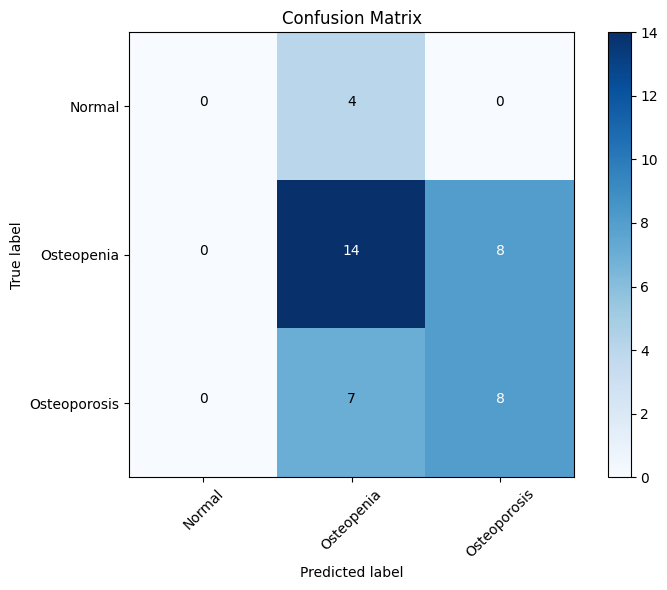

In [17]:
# Evaluate ResNet50
resnet_metrics = evaluate_model(resnet50_model, test_loader, device, class_names)

Evaluating Model: 100%|██████████| 3/3 [00:00<00:00, 16.22it/s]


EfficientNet Global Evaluation Metrics:
{'confusion_matrix': array([[ 0,  4,  0],
       [ 0, 16,  6],
       [ 0, 12,  3]], dtype=int64), 'accuracy': 0.4634146341463415, 'precision': 0.27777777777777773, 'recall': 0.3090909090909091, 'specificity': 0.6423751686909581, 'f1_score': 0.28086419753086417, 'auc_score': 0.43862743862743864, 'npv': 0.6202574525745258}


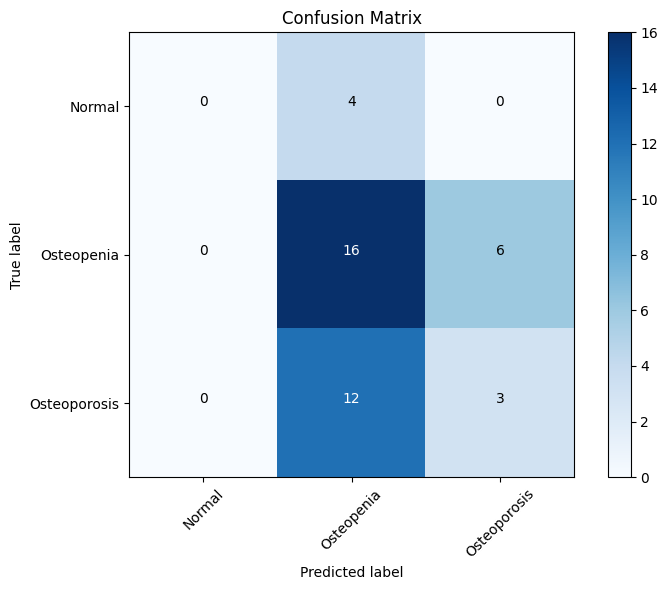

In [18]:
# Evaluate EfficientNetB3
effnet_metrics = evaluate_model(efficientnetb3_model, test_loader, device, class_names)